In [1]:
import sqlite3
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [2]:
def create_db_connection(db_file):
    """
    Create a database connection to the SQLite database
    specified by the db_file
    
    :param db_file: database file
    :return: Connection object or None
    """
    connection = None
    try:
        connection = sqlite3.connect(db_file)
    except Error as e:
        print(e)

    return connection

In [3]:
## Get data from Database

db_connection = create_db_connection("genres.db") # can be None!

# Read data as Pandas DataFrame
genres_data = pd.read_sql_query("SELECT * from genrepath", db_connection)
# Remove unnecessary data like 'filename'
genres_data = genres_data.drop('filename', axis=1)

# Encode Labels
genres_list = genres_data.iloc[:,-1]
encoder = LabelEncoder()
y = encoder.fit_transform(genres_list)

# Replace genres from 'genres_data' with encoded labels
genres_data['genre'] = y

# Print first five rows
genres_data.head()

,chroma_stft_mean,chroma_stft_var,rmse_mean,rmse_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,genre
0,0.349943,0.088760,0.130225,0.002829,1784.420446,129789.689238,2002.650192,85897.037189,3806.485316,9.016619e+05,...,52.459194,-1.691938,36.550671,-0.409953,41.642776,-2.300209,55.095062,1.219929,46.971302,0
1,0.340983,0.094981,0.095918,0.002373,1529.835316,375984.023922,2038.617579,213794.462833,3548.820207,2.976486e+06,...,55.364937,-0.716537,60.107063,0.293876,48.157219,-0.287431,51.128483,0.531573,45.825054,0
2,0.363603,0.085287,0.175573,0.002748,1552.481958,156526.317715,1747.165985,76046.707240,3040.514948,7.831159e+05,...,40.611088,-7.726901,47.675522,-1.815723,52.425117,-3.433434,46.624184,-2.226821,30.576181,0
3,0.404779,0.094009,0.141191,0.006339,1070.119953,184498.418348,1596.333948,166561.564811,2185.028454,1.494250e+06,...,44.460136,-3.316932,50.234367,0.637982,37.344990,-0.619690,37.298714,-3.408233,31.976847,0
4,0.308590,0.087850,0.091563,0.002304,1835.494603,343350.842007,1748.362448,88466.013315,3580.945013,1.572304e+06,...,86.031464,-5.453538,75.327110,-0.924161,53.583614,-4.409333,62.930351,-11.703781,55.235798,0


In [4]:
## Step 3: Transform and select features

# Separating features and target variable
train_data_features = genres_data.drop('genre', axis =1)

train_data_target = genres_data["genre"].copy()
train_data_target.columns = ['genre']

# Convert this to a Pandas DataFrame
train_data_target = pd.DataFrame(train_data_target)

print('Shape of features:', train_data_features.shape)
print('Shape of target:', train_data_target.shape)

print(train_data_features.info())
print(train_data_target.info())

# print features and targets
train_data_features.head(10)
train_data_target.head(10)

Shape of features: (1000, 57)
Shape of target: (1000, 1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 57 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   chroma_stft_mean         1000 non-null   float64
 1   chroma_stft_var          1000 non-null   float64
 2   rmse_mean                1000 non-null   float64
 3   rmse_var                 1000 non-null   float64
 4   spectral_centroid_mean   1000 non-null   float64
 5   spectral_centroid_var    1000 non-null   float64
 6   spectral_bandwidth_mean  1000 non-null   float64
 7   spectral_bandwidth_var   1000 non-null   float64
 8   rolloff_mean             1000 non-null   float64
 9   rolloff_var              1000 non-null   float64
 10  zero_crossing_rate_mean  1000 non-null   float64
 11  zero_crossing_rate_var   1000 non-null   float64
 12  harmonics_mean           1000 non-null   float64
 13  harmonics_var         

,genre
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [5]:
## Train a simple linear regression model

X_train, X_test, y_train, y_test = train_test_split(train_data_features, train_data_target, test_size=0.2, random_state=0)

lr = LinearRegression()
model = lr.fit(X_train, y_train)

# Make predictions using the trained model on test and training set
features_test_pred = model.predict(X_test)
features_train_pred = model.predict(X_train)

# Evaluate model on train set
RSME_train = metrics.mean_squared_error(y_train, features_train_pred)
RMSE_test = metrics.mean_squared_error(y_test, features_test_pred)


print("RMSE on Train set :", RSME_train)
print("RMSE on Test set :", RMSE_test)

RMSE on Train set : 5.311636227962017
RMSE on Test set : 5.661188197379298


In [6]:
# Predict genre using linear regression
from extract_features import extract

song_tuple = extract('../genres/jazz/jazz.00007.wav')
song = np.asarray(song_tuple).reshape(1, -1).astype(np.float)
song
encoder.inverse_transform([int(model.predict(song))])


array(['disco'], dtype=object)

# K-Means Clustering 

In the next section we try to use K means clustering to cluster the data in the genres

In [7]:
# K-means clustering
import matplotlib.pyplot as plt

#Initialize centroids as random data points
def initializeCentroids(X, labels, K):   
    centroids = np.zeros((K, X.shape[1]))
    for i in range (K):
        selected = labels == i
        selected_idx = np.where(selected)[0]
        random_idx = np.random.choice(selected_idx, size=1, replace=False)
        
        centroids[i, :] = X[random_idx, :]

    return centroids

#Plot the K means while progressing
def plotProgress(X, centroids, previous_centroids, idx, K, i):
    palette = plt.cm.hsv(np.linspace(0,1, num=K))
    
    colors = np.zeros((idx.shape[0], palette.shape[1]))
    for i in range(idx.shape[0]):
        colors[i, :] = palette[int(idx[i][0]), :]
        
    #Plot first two features
    plt.scatter(X[:, 0], X[:, 1], 15, colors)
    
    #Plot centroids
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='black', s=300)
    
    #Plot history of centroids
    #for i in range(centroids.shape[0]):
        #plt.scatter(centroids[i, :], previous_centroids[i, :2], color='black')
        #plt.plot([centroids[i, 0], previous_centroids[i, 0]], [centroids[i, 1], previous_centroids[i, :1]], color='black')
    
#Fint the closest centroid to each data point
def findClosestCentroids(X, centroids):
    K = centroids.shape[0]
    
    idx = np.zeros((X.shape[0], 1))
    
    for i in range(X.shape[0]):
        distance_from_centroids = np.zeros((K, 1))
        
        for j in range(K):
            
            distance_from_centroids[j] = np.linalg.norm(X[i, :] - centroids[j, :])**2
        
        idx[i] = np.argmin(distance_from_centroids)
    
    return idx

def computeCentroids(X, idx, K):
    centroids = np.zeros((K, X.shape[1]))
    
    for i in range(K):
        activated_by_id = idx == i
        n_activated = np.sum(activated_by_id)
        if n_activated:
            X_activated = np.multiply(activated_by_id, X)
            centroids[i, :] = X_activated.sum(axis=0) / n_activated
        
    return centroids

K-Means iteration 0/20...
Accuracy on dataset: 0.233
K-Means iteration 1/20...
Accuracy on dataset: 0.219
K-Means iteration 2/20...
Accuracy on dataset: 0.222
K-Means iteration 3/20...
Accuracy on dataset: 0.225
K-Means iteration 4/20...
Accuracy on dataset: 0.227
K-Means iteration 5/20...
Accuracy on dataset: 0.223
K-Means iteration 6/20...
Accuracy on dataset: 0.226
K-Means iteration 7/20...
Accuracy on dataset: 0.224
K-Means iteration 8/20...
Accuracy on dataset: 0.223
K-Means iteration 9/20...
Accuracy on dataset: 0.224
K-Means iteration 10/20...
Accuracy on dataset: 0.226
K-Means iteration 11/20...
Accuracy on dataset: 0.227
K-Means iteration 12/20...
Accuracy on dataset: 0.234
K-Means iteration 13/20...
Accuracy on dataset: 0.238
K-Means iteration 14/20...
Accuracy on dataset: 0.239
K-Means iteration 15/20...
Accuracy on dataset: 0.24
K-Means iteration 16/20...
Accuracy on dataset: 0.241
K-Means iteration 17/20...
Accuracy on dataset: 0.24
K-Means iteration 18/20...
Accuracy on d

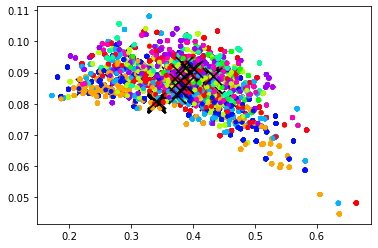

In [8]:
def getAccuracy(labels, prediction):
    return np.sum(labels == prediction)/labels.shape[0]

def runkMeans(X, initial_centroids, max_iters, plot_progress):
    centroids = initial_centroids
    previous_centroids = centroids
    for i in range (max_iters):
        print('K-Means iteration ' + str(i) + '/' + str(max_iters) + '...')
        
        idx = findClosestCentroids(X, centroids)
        
        if plot_progress:
            #Plot datapoints of first two columns 
            plotProgress(X, centroids, previous_centroids, idx, K, i)
            previous_centroids = centroids;
            #display.clear_output(wait=True)
            #display.display(pl.gcf())
        #input("Press enter to continue...")
        prediction = findClosestCentroids(train_data_features.values, centroids)
        accuracy = getAccuracy(train_data_target.values, prediction)
        print("Accuracy on dataset:", accuracy)
        centroids = computeCentroids(X, idx, K)
    return centroids

K = 10;

initial_centroids = initializeCentroids(train_data_features.values, train_data_target.values, K)

final_centroids = runkMeans(train_data_features.values, initial_centroids, 20, True)

#print(train_data_features.head())
#print(train_data_target.head())
prediction = findClosestCentroids(train_data_features.values, final_centroids)
print(getAccuracy(train_data_target.values, prediction))




# Different approaches

In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE


def model_assess(model, title):
    model.fit(X_train, np.ravel(y_train))
    preds = model.predict(X_test)
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5))
    
    
X_train, X_test, y_train, y_test = train_test_split(train_data_features, train_data_target, test_size=0.2, random_state=0)

### NO PRE-PROCESSING

print("*** NO PRE-PROCESSING ***")
    
# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Stochastic Gradient Descent")

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN")

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', max_iter=600, multi_class='multinomial')
model_assess(lg, "Logistic Regression")

# Neural Nets
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
model_assess(nn, "Neural Nets")

# Gaussian Process
#gpc = GaussianProcessClassifier(1.0 * RBF(1.0))
#model_assess(gpc, "Gaussian Process")

# AdaBoost
adc = AdaBoostClassifier()
model_assess(adc, "AdaBoost")

# GaussianNB
gnb = GaussianNB()
model_assess(nn, "GaussianNB")

# QUadratic Discriminant
qda = QuadraticDiscriminantAnalysis()
model_assess(qda, "Quadratic Discriminant Analysis")

*** NO PRE-PROCESSING ***
Accuracy Naive Bayes : 0.36
Accuracy Stochastic Gradient Descent : 0.225
Accuracy KNN : 0.305
Accuracy Decission trees : 0.48
Accuracy Random Forest : 0.62
Accuracy Support Vector Machine : 0.225


/home/shab/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Logistic Regression : 0.305


/home/shab/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy Neural Nets : 0.11
Accuracy AdaBoost : 0.345
Accuracy GaussianNB : 0.11
Accuracy Quadratic Discriminant Analysis : 0.435


/home/shab/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [10]:
### WITH PRE-PROCESSING


# Normalize so everything is on the same scale. 
cols = train_data_features.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(train_data_features)

# new data frame with the new scaled data. 
X = pd.DataFrame(np_scaled, columns = cols)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("*** WITH PRE-PROCESSING ***")

# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Stochastic Gradient Descent")

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN")

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', max_iter=600, multi_class='multinomial')
model_assess(lg, "Logistic Regression")

# Neural Nets
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
model_assess(nn, "Neural Nets")

# Gaussian Process
gpc = GaussianProcessClassifier(1.0 * RBF(1.0))
model_assess(gpc, "Gaussian Process")

# AdaBoost
adc = AdaBoostClassifier()
model_assess(adc, "AdaBoost")

# GaussianNB
gnb = GaussianNB()
model_assess(nn, "GaussianNB")

# QUadratic Discriminant
qda = QuadraticDiscriminantAnalysis()
model_assess(qda, "Quadratic Discriminant Analysis")

# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess(xgb, "Cross Gradient Booster")

# Cross Gradient Booster (Random Forest)
xgbrf = XGBRFClassifier(objective= 'multi:softmax')
model_assess(xgbrf, "Cross Gradient Booster (Random Forest)")

*** WITH PRE-PROCESSING ***
Accuracy Naive Bayes : 0.51333
Accuracy Stochastic Gradient Descent : 0.65333
Accuracy KNN : 0.57333
Accuracy Decission trees : 0.47
Accuracy Random Forest : 0.67667
Accuracy Support Vector Machine : 0.63333
Accuracy Logistic Regression : 0.60667


/home/shab/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy Neural Nets : 0.63667
Accuracy Gaussian Process : 0.75333
Accuracy AdaBoost : 0.31333


/home/shab/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy GaussianNB : 0.63667
Accuracy Quadratic Discriminant Analysis : 0.38667
Accuracy Cross Gradient Booster : 0.7
Accuracy Cross Gradient Booster (Random Forest) : 0.64333


In [11]:
### STANDARD SCALER

scaler = preprocessing.StandardScaler()
np_scaled = scaler.fit_transform(train_data_features)

# new data frame with the new scaled data. 
X = pd.DataFrame(np_scaled, columns = cols)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("*** WITH PRE-PROCESSING ***")

# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Stochastic Gradient Descent")

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN")

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', max_iter=600, multi_class='multinomial')
model_assess(lg, "Logistic Regression")

# Neural Nets
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
model_assess(nn, "Neural Nets")

# Gaussian Process
gpc = GaussianProcessClassifier(1.0 * RBF(1.0))
model_assess(gpc, "Gaussian Process")

# AdaBoost
adc = AdaBoostClassifier()
model_assess(adc, "AdaBoost")

# GaussianNB
gnb = GaussianNB()
model_assess(nn, "GaussianNB")

# QUadratic Discriminant
qda = QuadraticDiscriminantAnalysis()
model_assess(qda, "Quadratic Discriminant Analysis")

# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess(xgb, "Cross Gradient Booster")

# Cross Gradient Booster (Random Forest)
xgbrf = XGBRFClassifier(objective= 'multi:softmax')
model_assess(xgbrf, "Cross Gradient Booster (Random Forest)")

*** WITH PRE-PROCESSING ***
Accuracy Naive Bayes : 0.51333
Accuracy Stochastic Gradient Descent : 0.63667
Accuracy KNN : 0.57333
Accuracy Decission trees : 0.45667
Accuracy Random Forest : 0.67667
Accuracy Support Vector Machine : 0.69
Accuracy Logistic Regression : 0.70333
Accuracy Neural Nets : 0.66
Accuracy Gaussian Process : 0.73
Accuracy AdaBoost : 0.31333
Accuracy GaussianNB : 0.66
Accuracy Quadratic Discriminant Analysis : 0.38667
Accuracy Cross Gradient Booster : 0.7
Accuracy Cross Gradient Booster (Random Forest) : 0.64333
